In [82]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import desc
import pyspark.sql.functions as fn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Information

(1) hotel: Type of the hotel 
(2) is_canceled: Value indicating if the booking was canceled (1) or not (0)   
(3) lead_time: Number of days that elapsed between the entering date of the booking into the PMS and the arrival date    
(4) arrival_date_year: Year number of year for arrival date 
(5) arrival_date_month: Month number of year for arrival date 
(6) arrival_date_week: Week number of year for arrival date 
(7) arrival_date_day: Day number of year for arrival date 
(8) stays_in_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel 
(9) stays_in_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel 
(10) adults: Number of adults 
(11) children: Number of children 
(12) babies: Number of babies   
(13) meal: Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC – no meal package;      BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch        and dinner) 
(14) country: Country of origin. Categories are represented in the ISO 3155–3:2013 format 
(15) market_segment: Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour              Operators” 
(16) distribution_channel: Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators” 
(17) is_repeated_guest: Value indicating if the booking name was from a repeated guest (1) or not (0) 
(18) previous_cancellations:Number of previous bookings that were cancelled by the customer prior to the current booking 
(19) previous_bookings_not_canceled: Number of previous bookings not cancelled by the customer prior to the current booking 
(20) reserved_room_type: Code of room type reserved. Code is presented instead of designation for anonymity reasons. 
(21) assigned_room_type: Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the        reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of        designation for anonymity reasons. 
(22) booking_changes: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until      the moment of check-in or cancellation 
(23) deposit_type: Indication on if the customer made a deposit to guarantee the booking. This variable can assume three              categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost;              Refundable – a deposit was made with a value under the total cost of stay 
(24) agent: ID of the travel agency that made the booking 
(25) company: ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of        designation for anonymity reasons 
(26) days_in_waiting_list: Number of days the booking was in the waiting list before it was confirmed to the customer 
(27) customer_type: Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type      of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part        of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient,      but is associated to at least other transient booking 
(28) adr: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights 
(29) required_car_parking_spaces: Number of car parking spaces required by the customer 
(30) total_of_special_requests: Number of special requests made by the customer (e.g. twin bed or high floor) 
(31) reservation_status: Reservation last status, assuming one of three categories: Canceled – booking was canceled by the            customer; Check-Out – customer has checked in but already departed; No-Show – customer did not check-in and did inform the      hotel of the reason why 
(32) reservation_status_date: Date at which the last status was set. This variable can be used in conjunction with the                ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel

** Data information url: https://www.kaggle.com/jessemostipak/hotel-booking-demand

# Import data

In [83]:
spark = SparkSession.builder.appName('job').getOrCreate()
df = spark.read.csv(r'C:\Users\zhiya\Desktop\3208_project\hotel_bookings.csv', inferSchema=True, header=True)
df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

In [3]:
print("Number of rows: ", df.count())
print("Number of columns: ", len(df.columns))

df.groupby("is_canceled").count().toPandas()

Number of rows:  119390
Number of columns:  32


is_canceled  count
0            1  44224
1            0  75166

# Data cleaning

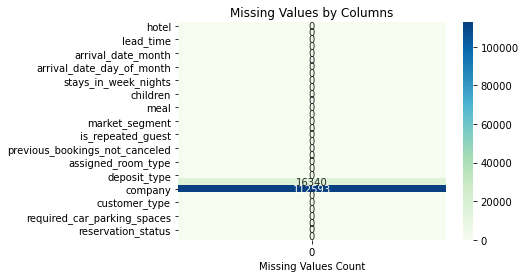

Proportion of missing values:
 hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               0
babies                                 0
meal                                   0
country                                0
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                     

In [4]:
# Check if there are null values or NaN values in each column

plt.title('Missing Values by Columns')
ax = sns.heatmap(df.toPandas().isna().sum().to_frame(), annot=True,fmt='d', cmap='GnBu')
ax.set_xlabel('Missing Values Count')
plt.show()

print("Proportion of missing values:\n", df.toPandas().isna().sum())

# Can be seen there are 112593 missing values in "company" column and 16340 missing values in "agent" column
# I choose to drop these two columns

In [84]:
# Drop these 2 columns

columns_to_drop = ['company', 'agent']
df = df.drop(*columns_to_drop)
df.toPandas()

hotel  is_canceled  lead_time  arrival_date_year  \
0       Resort Hotel            0        342               2015   
1       Resort Hotel            0        737               2015   
2       Resort Hotel            0          7               2015   
3       Resort Hotel            0         13               2015   
4       Resort Hotel            0         14               2015   
...              ...          ...        ...                ...   
119385    City Hotel            0         23               2017   
119386    City Hotel            0        102               2017   
119387    City Hotel            0         34               2017   
119388    City Hotel            0        109               2017   
119389    City Hotel            0        205               2017   

       arrival_date_month  arrival_date_week_number  \
0                    July                        27   
1                    July                        27   
2                    July                        27   
3                    July                        27   
4                    July                        27   
...                   ...                       ...   
119385             August                        35   
119386             August                        35   
119387             August                        35   
119388             August                        35   
119389             August                        35   

        arrival_date_day_of_month  stays_in_weekend_nights  \
0                               1                        0   
1                               1                        0   
2                               1                        0   
3                               1                        0   
4                               1                        0   
...                           ...                      ...   
119385                         30                        2   
119386                         31                        2   
119387                         31                        2   
119388                         31                        2   
119389                         29                        2   

        stays_in_week_nights  adults  ... assigned_room_type  booking_changes  \
0                          0       2  ...                  C                3   
1                          0       2  ...                  C                4   
2                          1       1  ...                  C                0   
3                          1       1  ...                  A                0   
4                          2       2  ...                  A                0   
...                      ...     ...  ...                ...              ...   
119385                     5       2  ...                  A                0   
119386                     5       3  ...                  E                0   
119387                     5       2  ...                  D                0   
119388                     5       2  ...                  A                0   
119389                     7       2  ...                  A                0   

       deposit_type days_in_waiting_list customer_type     adr  \
0        No Deposit                    0     Transient    0.00   
1        No Deposit                    0     Transient    0.00   
2        No Deposit                    0     Transient   75.00   
3        No Deposit                    0     Transient   75.00   
4        No Deposit                    0     Transient   98.00   
...             ...                  ...           ...     ...   
119385   No Deposit                    0     Transient   96.14   
119386   No Deposit                    0     Transient  225.43   
119387   No Deposit                    0     Transient  157.71   
119388   No Deposit                    0     Transient  104.40   
119389   No Deposit                    0     Transient  151.20   

        required_car_parking_spaces  t

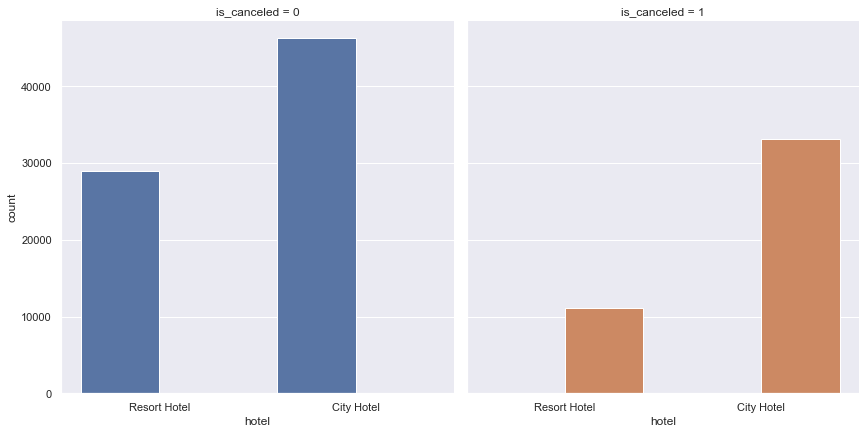

In [6]:
sns.set_theme(style="darkgrid")

plot1 = sns.catplot(x="hotel", hue="is_canceled", col="is_canceled", data=df.toPandas(), kind="count", height=6);

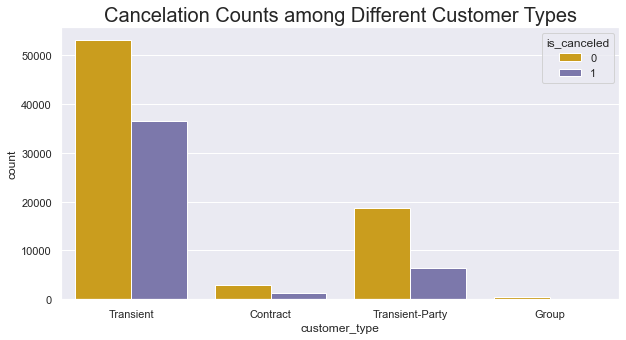

In [7]:
plt.figure(figsize=(10, 5))

sns.countplot(x='customer_type',hue="is_canceled", data=df.toPandas(), palette='Dark2_r')
plt.title("Cancelation Counts among Different Customer Types", size=20)
plt.show()

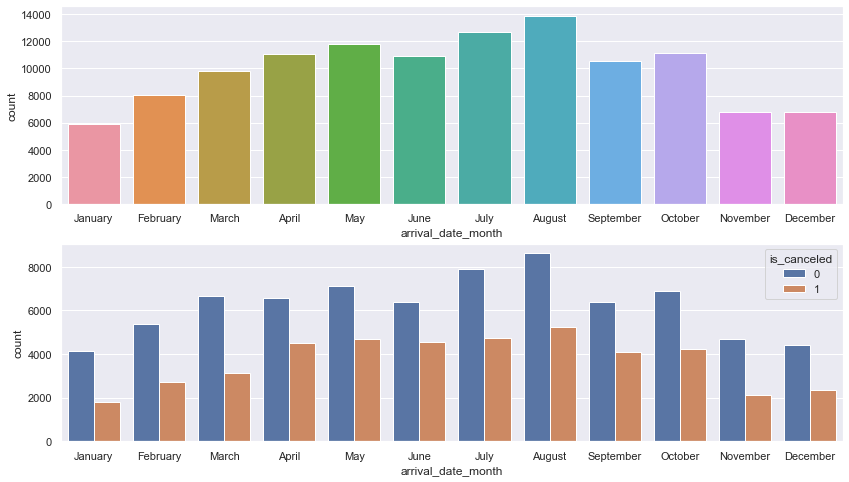

In [8]:
n_rows = 2
n_cols = 1

sort_months = ['January','February', 'March' ,'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

_, ax = plt.subplots(n_rows, n_cols, figsize=(14,8))

# Count the number of customers for each month
sns.countplot(x='arrival_date_month', data=df.toPandas(), ax=ax[0], order=sort_months)

# Count the number of customers for each month (canceled customers and no-canceled customers)
sns.countplot(x='arrival_date_month', data=df.toPandas(), hue='is_canceled', ax=ax[1], order=sort_months)
plt.show()

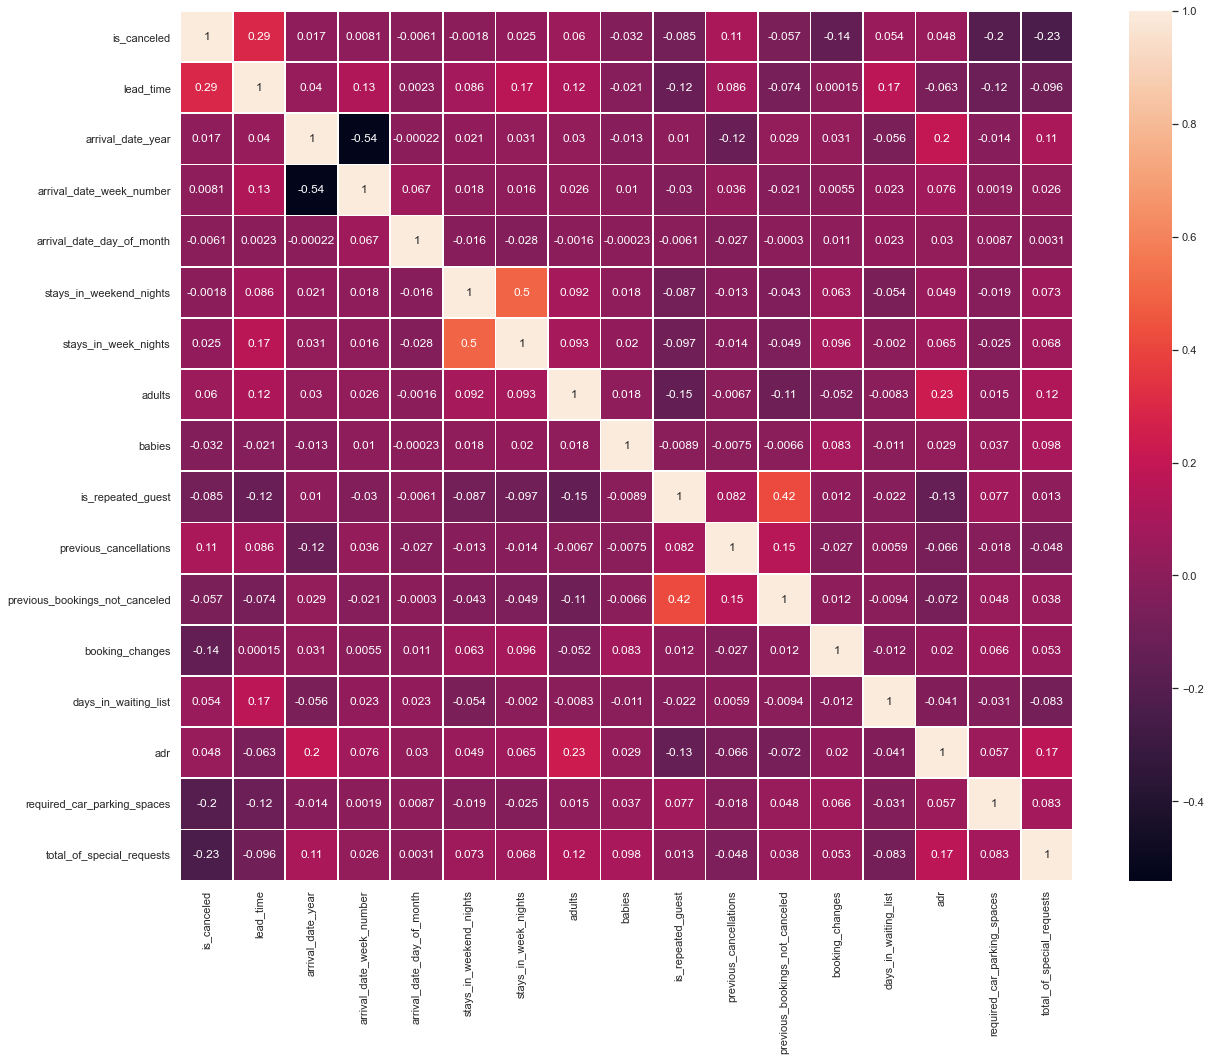

In [9]:
# Correlations between each attributes (heatmap)
plt.figure(figsize = (20, 16))

corr = df.toPandas().corr()
sns.heatmap(corr, linewidths=.8, annot=True)

plt.show()

In [10]:
# Sort the correlations with "is_canceled", since I set it as label
correlation = df.toPandas().corr()['is_canceled'].abs()
sort_correlation = correlation.sort_values(ascending=False)
sort_correlation

is_canceled                       1.000000
lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

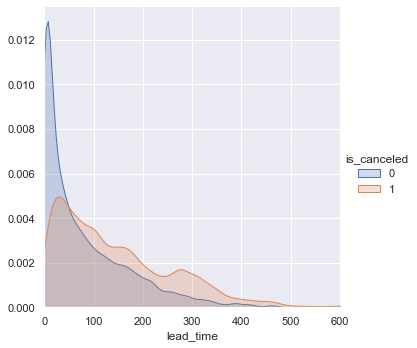

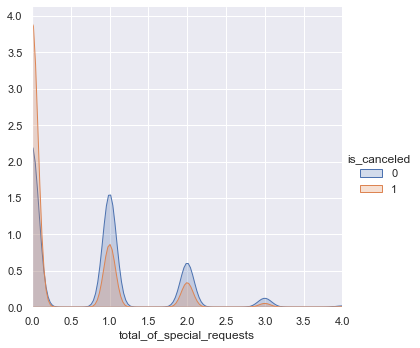

In [11]:
# Plot the first two correlated features with kernel density
plot = (sns.FacetGrid(df.toPandas(), hue = 'is_canceled', height = 5, xlim = (0,600))
.map(sns.kdeplot, 'lead_time', shade = True)
.add_legend())

plot = (sns.FacetGrid(df.toPandas(), hue = 'is_canceled', height = 5, xlim = (0,4))
.map(sns.kdeplot, 'total_of_special_requests', shade = True)
.add_legend())

In [85]:
df = df.select('hotel', 'is_canceled', 'lead_time', 'arrival_date_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 
               'adults', 'children', 'babies', 'meal', 'market_segment', 'distribution_channel', 'is_repeated_guest', 
               'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 
               'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 
               'total_of_special_requests', 'reservation_status')

df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: integer (nullable = true)
 |-- deposit_type: string (nullable = true)
 |-- days_in_waiting_list: integer (nullable = true)
 |-- customer_type: string (nullable = true)
 |-

# Data preparing for Machine Learning

In [86]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categorical_cols = ['hotel', 'arrival_date_month', 'children', 'meal', 'market_segment', 'distribution_channel', 
                    'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']

stages = []

for attr in categorical_cols:
    stringIndexer = StringIndexer(inputCol = attr, outputCol = attr + 'Index')
    encoder = OneHotEncoder(inputCols = [stringIndexer.getOutputCol()], outputCols = [attr + "classVec"])
    stages += [stringIndexer, encoder]

    
label_index = StringIndexer(inputCol = 'is_canceled', outputCol = 'label')
stages += [label_index]

numerical_cols = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'babies', 
                  'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 
                  'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']

assemblerInputs = [c + "classVec" for c in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol = 'features')
stages += [assembler]

In [81]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + df.columns
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: integer (nullable = true)
 |-- deposit_type: string (nullable = true)
 |-- days_in_waiting_li